In [ ]:
!apt update
!apt install -y python3-rosbag

In [ ]:

import rosbag
import csv
import struct
bag_file_path = '/content/d435i_walking.bag'

try:
    bag = rosbag.Bag(bag_file_path, 'r')
    # Your processing code here
finally:
    bag.close()


In [ ]:
import rosbag
import csv
import struct

# Ścieżka do pliku '.bag'
bag_file_path = '/content/d435i_walking.bag'

# Lista topic'ów do odczytu
desired_topics = [
    '/device_0/sensor_2/Accel_0/imu/data',
    '/device_0/sensor_2/Gyro_0/imu/data',
    '/device_0/sensor_0/Depth_0/image/data',
    '/device_0/sensor_1/Color_0/image/data'
]

def write_imu_csv(csv_writer, msg, t):
    csv_writer.writerow([t, msg.linear_acceleration.x, msg.linear_acceleration.y, msg.linear_acceleration.z,
                         msg.angular_velocity.x, msg.angular_velocity.y, msg.angular_velocity.z])

def write_image_csv(csv_writer, msg, t):
    img_data = struct.unpack(str(len(msg.data)) + 'B', msg.data)
    csv_writer.writerow([t, msg.width, msg.height, msg.encoding, msg.step, img_data])

# Otwórz pliki CSV do zapisu danych
csv_files = {}
csv_writers = {}
for topic in desired_topics:
    csv_files[topic] = open(f'{topic.replace("/", "_")}.csv', 'w', newline='')
    csv_writers[topic] = csv.writer(csv_files[topic], delimiter=',')
    if 'imu' in topic.lower():
        csv_writers[topic].writerow(['timestamp', 'linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z',
                                      'angular_velocity_x', 'angular_velocity_y', 'angular_velocity_z'])
    elif 'image' in topic.lower():
        csv_writers[topic].writerow(['timestamp', 'width', 'height', 'encoding', 'step', 'image_data'])
    else:
        csv_writers[topic].writerow(['timestamp', 'data'])

try:
    bag = rosbag.Bag(bag_file_path, 'r')

    # Zapisz dane do odpowiednich plików CSV
    for topic, msg, t in bag.read_messages(topics=desired_topics):
        if topic in desired_topics:
            if 'imu' in topic.lower():
                write_imu_csv(csv_writers[topic], msg, t)
            elif 'image' in topic.lower():
                write_image_csv(csv_writers[topic], msg, t)
            else:
                # Dla innych tematów, zapisz ogólną informację
                csv_writers[topic].writerow([t, msg.data if hasattr(msg, 'data') and isinstance(msg.data, bytes) else str(msg.data)])

finally:
    # Zamknij pliki CSV
    for file in csv_files.values():
        file.close()

    # Zamknij plik '.bag'
    bag.close()


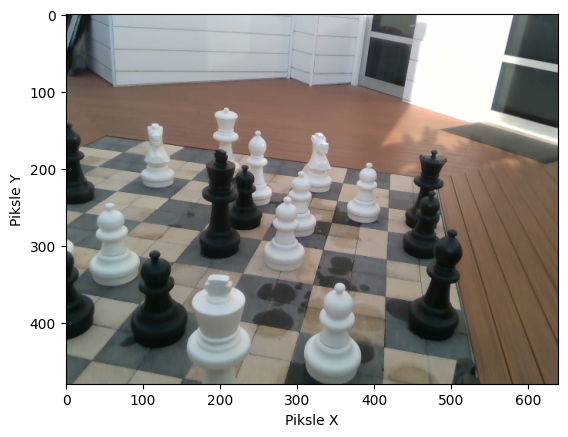

In [ ]:
import rosbag
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Ścieżka do pliku '.bag'
bag_file_path = '/content/d435i_walking.bag'

# Wybrany temat obrazu kolorowego
color_image_topic = '/device_0/sensor_1/Color_0/image/data'

# Wczytaj plik '.bag'
bag = rosbag.Bag(bag_file_path, 'r')

# Znajdź pierwszą wiadomość z tematu obrazu kolorowego
for topic, msg, t in bag.read_messages(topics=[color_image_topic]):
    color_image_msg = msg
    break

# Zamknij plik '.bag'
bag.close()

# Rozpakuj dane obrazu kolorowego
img_data = np.frombuffer(color_image_msg.data, dtype=np.uint8)

# Spróbuj dekodować obraz za pomocą biblioteki Pillow
try:
    color_image = Image.frombytes('RGB', (color_image_msg.width, color_image_msg.height), img_data)
    color_image = np.array(color_image)

    # Wyświetl pseudorzut z góry
    plt.imshow(color_image)
    plt.xlabel('Piksle X')
    plt.ylabel('Piksle Y')
    plt.show()

except Exception as e:
    print(f"Błąd podczas dekodowania obrazu: {e}")


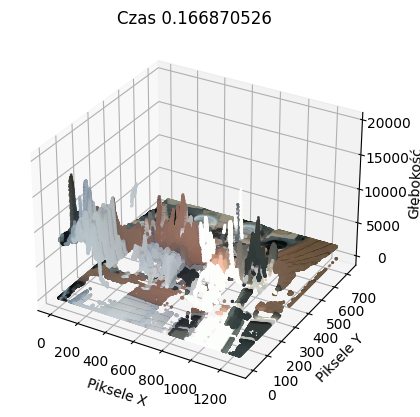

In [ ]:
import rosbag
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Ścieżka do pliku '.bag'
bag_file_path = '/content/d435i_walking.bag'

# Wybrane tematy obrazu kolorowego i głębokości
color_image_topic = '/device_0/sensor_1/Color_0/image/data'
depth_image_topic = '/device_0/sensor_0/Depth_0/image/data'

# Wczytaj plik '.bag'
bag = rosbag.Bag(bag_file_path, 'r')

# Znajdź pierwszą wiadomość z tematu obrazu kolorowego
for topic, msg, t in bag.read_messages(topics=[color_image_topic]):
    color_image_msg = msg
    break

# Znajdź pierwszą wiadomość z tematu obrazu głębokości
for topic, msg, t in bag.read_messages(topics=[depth_image_topic]):
    depth_image_msg = msg
    break

# Zamknij plik '.bag'
bag.close()

# Rozpakuj dane obrazów
color_img_data = np.frombuffer(color_image_msg.data, dtype=np.uint8)
depth_img_data = np.frombuffer(depth_image_msg.data, dtype=np.uint16)

# Spróbuj dekodować obrazy za pomocą biblioteki Pillow
try:
    color_image = Image.frombytes('RGB', (color_image_msg.width, color_image_msg.height), color_img_data)
    color_image = np.array(color_image)

    depth_image = Image.frombytes('I;16', (depth_image_msg.width, depth_image_msg.height), depth_img_data)
    depth_image = np.array(depth_image)

    # Dopasuj rozmiary obrazów do siebie
    color_image_resized = np.array(Image.fromarray(color_image).resize((depth_image.shape[1], depth_image.shape[0])))

    # Przygotuj współrzędne pikseli
    X, Y = np.meshgrid(np.arange(color_image_resized.shape[1]), np.arange(color_image_resized.shape[0]))

    # Przygotuj współrzędne RGB jako jednowymiarowe tablice
    colors = color_image_resized.reshape((-1, 3)) / 255.0

    # Utwórz trójwymiarowy wykres scatter
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Wyświetl piksele jako punkty o kolorach RGB z uwzględnieniem głębokości
    ax.scatter(X.flatten(), Y.flatten(), depth_image.flatten(), s=1, c=colors)

    # Dodaj etykiety
    ax.set_xlabel('Piksele X')
    ax.set_ylabel('Piksele Y')
    ax.set_zlabel('Głębokość')
    ax.set_title('Czas 0.166870526')
    # Wyświetl wykres
    plt.show()


except Exception as e:
    print(f"Błąd podczas dekodowania obrazów: {e}")
